In [1]:
!pip install lpips scikit-image


In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from glob import glob
from skimage.exposure import match_histograms
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import lpips
import matplotlib.pyplot as plt


In [3]:
data_path = "C:/Users/HP/Desktop/internship/our485"
image_list = os.listdir(data_path)



In [10]:
class LOLDataset(Dataset):
    def __init__(self, low_dir, high_dir, transform=None):
        self.low_paths = sorted(glob(os.path.join(low_dir, '*.png')))
        self.high_paths = sorted(glob(os.path.join(high_dir, '*.png')))
        self.transform = transform
        
        # CRITICAL FIX: Ensure both lists have the same length
        print(f"Found {len(self.low_paths)} low-light images")
        print(f"Found {len(self.high_paths)} high-light images")
        
        min_length = min(len(self.low_paths), len(self.high_paths))
        if min_length == 0:
            raise ValueError("No matching images found in directories")
            
        self.low_paths = self.low_paths[:min_length]
        self.high_paths = self.high_paths[:min_length]
        
        print(f"Dataset initialized with {len(self.low_paths)} image pairs")
        
    def __len__(self):
        return len(self.low_paths)
        
    def __getitem__(self, idx):
        try:
            # CRITICAL FIX: Bounds checking
            if idx >= len(self.low_paths) or idx >= len(self.high_paths):
                print(f"Warning: Index {idx} out of range. Using last valid index.")
                idx = min(len(self.low_paths) - 1, len(self.high_paths) - 1)
            
            low = Image.open(self.low_paths[idx]).convert('RGB')
            high = Image.open(self.high_paths[idx]).convert('RGB')
            
            if self.transform:
                low = self.transform(low)
                high = self.transform(high)
            
            hist = self._compute_histogram(low)
            tf_gt = self._compute_transformation(low, high)
            
            return low, high, hist, tf_gt
            
        except Exception as e:
            print(f"Error loading sample {idx}: {str(e)}")
            # Return dummy data to prevent crash
            if hasattr(self, 'transform') and self.transform:
                dummy_size = (3, 256, 256)  # Adjust based on your transform output size
            else:
                dummy_size = (3, 256, 256)
            
            dummy_low = torch.zeros(dummy_size)
            dummy_high = torch.zeros(dummy_size)
            dummy_hist = torch.ones(1, 256) / 256  # Normalized histogram
            dummy_tf = torch.zeros(3)
            
            return dummy_low, dummy_high, dummy_hist, dummy_tf
    
    def _compute_histogram(self, img):
        try:
            # Ensure img is a tensor and in correct range [0, 1]
            if not isinstance(img, torch.Tensor):
                img = torch.tensor(img)
            
            # Convert to grayscale for histogram if needed
            if img.dim() == 3 and img.shape[0] == 3:
                img_gray = 0.299 * img[0] + 0.587 * img[1] + 0.114 * img[2]
            else:
                img_gray = img.flatten()
            
            # Ensure values are in [0, 1] range
            img_gray = torch.clamp(img_gray, 0, 1)
            
            h = torch.histc(img_gray, bins=256, min=0, max=1).reshape(1, -1)
            
            # Avoid division by zero
            if h.sum() > 0:
                return h / h.sum()
            else:
                return torch.ones(1, 256) / 256
                
        except Exception as e:
            print(f"Error computing histogram: {str(e)}")
            return torch.ones(1, 256) / 256
    
    def _compute_transformation(self, low, high):
        try:
            # Convert tensors to numpy for skimage processing
            if isinstance(low, torch.Tensor):
                low_np = low.permute(1, 2, 0).numpy()
            else:
                low_np = low
                
            if isinstance(high, torch.Tensor):
                high_np = high.permute(1, 2, 0).numpy()
            else:
                high_np = high
            
            # Ensure values are in correct range [0, 1]
            low_np = np.clip(low_np, 0, 1)
            high_np = np.clip(high_np, 0, 1)
            
            matched = match_histograms(high_np, low_np, channel_axis=-1)
            tf = (matched - low_np).mean(axis=(0, 1))
            
            return torch.tensor(tf, dtype=torch.float32)
            
        except Exception as e:
            print(f"Error computing transformation: {str(e)}")
            return torch.zeros(3, dtype=torch.float32)

In [11]:
# Initialize LPIPS
lpips_fn = lpips.LPIPS(net='alex')

def image_loss(pred, target):
    return F.mse_loss(pred, target)

def color_loss(pred, target):
    return 1 - F.cosine_similarity(pred.flatten(1), target.flatten(1)).mean()

def tf_loss(pred_tf, gt_tf):
    # pred_tf shape: [batch, 3, 256] or [batch, 3]
    # gt_tf shape: [batch, 3]
    try:
        if pred_tf.dim() == 3 and pred_tf.shape[-1] == 256:
            # Compare the mean of predicted transformation with the ground truth
            pred_mean = pred_tf.mean(dim=2)  # shape: [B, 3]
            return F.l1_loss(pred_mean, gt_tf)
        elif pred_tf.dim() == 2:
            # If already 2D, use directly
            return F.l1_loss(pred_tf, gt_tf)
        else:
            print(f"Unexpected pred_tf shape in tf_loss: {pred_tf.shape}")
            return torch.tensor(0.0, device=pred_tf.device, requires_grad=True)
    except Exception as e:
        print(f"Error in tf_loss: {str(e)}")
        return torch.tensor(0.0, device=pred_tf.device, requires_grad=True)

def monotonicity_loss(tf):
    # tf shape: [batch, 3, 256]
    try:
        if tf.dim() == 3 and tf.shape[-1] == 256:
            # Penalize non-monotonicity (negative differences) along the 256 bins
            diff = tf[:, :, 1:] - tf[:, :, :-1]  # [batch, 3, 255]
            return torch.mean(torch.relu(-diff))  # Penalize negative differences
        else:
            print(f"Unexpected tf shape in monotonicity_loss: {tf.shape}")
            return torch.tensor(0.0, device=tf.device, requires_grad=True)
    except Exception as e:
        print(f"Error in monotonicity_loss: {str(e)}")
        return torch.tensor(0.0, device=tf.device, requires_grad=True)

def compute_metrics(pred, gt):
    try:
        pred_np = pred.permute(1, 2, 0).cpu().numpy()
        gt_np = gt.permute(1, 2, 0).cpu().numpy()
        return (
            psnr(gt_np, pred_np, data_range=1.0),
            ssim(gt_np, pred_np, data_range=1.0, channel_axis=2)
        )
    except Exception as e:
        print(f"Error in compute_metrics: {str(e)}")
        return 0.0, 0.0  # Return default values to avoid breaking the loop

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: C:\Users\HP\miniconda3\Lib\site-packages\lpips\weights\v0.1\alex.pth


In [12]:
class AFCBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(6, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 1)

    def forward(self, x, a):
        x_cat = torch.cat([x, a], dim=1)
        return self.conv2(F.relu(self.conv1(x_cat)))

class SFCBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 64, 3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        return x

class RHA(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(64 + 256, 512)
        self.fc2 = nn.Linear(512, 768)

    def forward(self, f_img, hist):
        hist = hist.view(hist.size(0), -1)
        fused = torch.cat([f_img, hist], dim=1)
        out = torch.tanh(self.fc2(F.relu(self.fc1(fused))))
        return out.view(-1, 3, 256)

class AttentionNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)
class HTFNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.attn = AttentionNet()
        self.afc = AFCBlock()
        self.sfc = SFCBlock()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.rha = RHA()

    def forward(self, x):
        attn = self.attn(x)
        f = self.afc(x, attn)
        f = self.sfc(f)
        f = self.pool(f).flatten(1)
        tf = self.rha(f, self.hist)

        x_flat = (x * 255).long().clamp(0, 255)  # [B, 3, H, W]
        b, c, h, w = x.shape
        out = torch.zeros_like(x)

        for ch in range(3):
            idx = x_flat[:, ch, :, :].view(b, -1)  # [B, H*W]
            tf_ch = tf[:, ch, :]                   # [B, 256]
            tf_map = tf_ch.gather(1, idx)          # [B, H*W]

            mean_tf = tf_map.mean(dim=1, keepdim=True)  # [B, 1]
            centered_tf = tf_map - mean_tf              # [B, H*W]

            adjusted = x[:, ch, :, :] + (centered_tf.view(b, h, w) / 255.0)
            out[:, ch, :, :] = adjusted.clamp(0, 1)

        return out.clamp(0, 1), tf

    def set_hist(self, hist):
        self.hist = hist


In [13]:
# Add PSNR calculation function
def calculate_psnr(img1, img2, max_val=1.0):
    """Calculate PSNR between two images"""
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    psnr = 20 * torch.log10(max_val / torch.sqrt(mse))
    return psnr.item()

# Add SSIM calculation function (simplified version)
def calculate_ssim(img1, img2, window_size=11, max_val=1.0):
    """Calculate SSIM between two images (simplified)"""
    # Convert to grayscale if RGB
    if img1.dim() == 4:  # Batch dimension
        img1 = img1.mean(dim=1, keepdim=True)
        img2 = img2.mean(dim=1, keepdim=True)
    elif img1.dim() == 3 and img1.shape[0] == 3:  # RGB
        img1 = img1.mean(dim=0, keepdim=True)
        img2 = img2.mean(dim=0, keepdim=True)
    
    # Simple SSIM approximation using correlation
    mu1 = torch.mean(img1)
    mu2 = torch.mean(img2)
    
    sigma1_sq = torch.var(img1)
    sigma2_sq = torch.var(img2)
    sigma12 = torch.mean((img1 - mu1) * (img2 - mu2))
    
    c1 = (0.01 * max_val) ** 2
    c2 = (0.03 * max_val) ** 2
    
    ssim = ((2 * mu1 * mu2 + c1) * (2 * sigma12 + c2)) / ((mu1**2 + mu2**2 + c1) * (sigma1_sq + sigma2_sq + c2))
    return ssim.item()

transform = T.Compose([T.Resize((256, 256)), T.ToTensor()])

# ✅ Use raw strings or forward slashes
low_dir = r"C:\Users\HP\Desktop\internship\our485\low"
high_dir = r"C:\Users\HP\Desktop\internship\our485\high"

# Check if directories exist and have images
low_images = sorted(glob(os.path.join(low_dir, '*.png')))
high_images = sorted(glob(os.path.join(high_dir, '*.png')))

print(f"Found {len(low_images)} low-light images")
print(f"Found {len(high_images)} high-light images")

if len(low_images) == 0 or len(high_images) == 0:
    raise ValueError(f"No images found in the dataset folders.\nLow: {low_dir}\nHigh: {high_dir}")

# Create dataset with the FIXED class
trainset = LOLDataset(low_dir, high_dir, transform=transform)

# ✅ IMPORTANT: Add drop_last=True and num_workers=0 for stability
dataloader = DataLoader(trainset, batch_size=4, shuffle=True, drop_last=True, num_workers=0)

print(f"Dataset contains {len(trainset)} samples")
print(f"Dataloader will produce {len(dataloader)} batches per epoch")

# Device and model setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = HTFNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# ✅ Initialize metrics storage for plotting
psnr_vals = []
ssim_vals = []
loss_history = []
epoch_numbers = []


Found 493 low-light images
Found 485 high-light images
Found 493 low-light images
Found 485 high-light images
Dataset initialized with 485 image pairs
Dataset contains 485 samples
Dataloader will produce 121 batches per epoch
Using device: cpu


In [16]:
# Optimized Training Loop - Calculate metrics only at epoch end
print("Starting optimized training...")

best_loss = float('inf')
best_psnr = 0.0
best_ssim = 0.0

for epoch in range(20):
    model.train()
    epoch_losses = []
    
    # Store predictions from last batch only for metrics
    last_batch_pred = None
    last_batch_target = None
    
    # For displaying current metrics during training
    current_psnr = 0.0
    current_ssim = 0.0
    
    print(f"\n--- Epoch {epoch+1}/20 ---")
    
    for batch_idx, batch in enumerate(dataloader):
        x, y, h, tf_gt = batch
        
        # Fix h shape if needed
        if h.dim() == 2:
            h = h.unsqueeze(1)
        elif h.dim() == 3 and h.shape[1] != 1:
            h = h.unsqueeze(1)
        
        # Ensure tf_gt is float and has correct shape
        tf_gt = tf_gt.float()
        if tf_gt.dim() == 1:
            tf_gt = tf_gt.unsqueeze(0)
        
        x, y, h, tf_gt = x.to(device), y.to(device), h.to(device), tf_gt.to(device)
        
        # Forward pass
        model.set_hist(h)
        y_hat, tf = model(x)
        
        # Loss calculation
        mse_loss = nn.MSELoss()(y_hat, y)
        
        # TF loss
        if tf.dim() == 3 and tf.shape[-1] == 256:
            tf_reduced = tf.mean(dim=-1)
        elif tf.dim() == 2:
            tf_reduced = tf
        else:
            tf_reduced = tf.view(tf.shape[0], -1)[:, :3]
        
        # Ensure tf_reduced and tf_gt have same shape
        if tf_reduced.shape != tf_gt.shape:
            min_dim = min(tf_reduced.shape[1], tf_gt.shape[1])
            tf_reduced = tf_reduced[:, :min_dim]
            tf_gt = tf_gt[:, :min_dim]
        
        tf_mse_loss = nn.MSELoss()(tf_reduced, tf_gt)
        total_loss = mse_loss + 0.1 * tf_mse_loss
        
        # Calculate metrics for progress display every 50 batches
        if batch_idx % 50 == 0:
            with torch.no_grad():
                # Quick metrics calculation on first few samples of current batch
                temp_pred = torch.clamp(y_hat[:min(4, y_hat.size(0))].detach().cpu(), 0, 1)
                temp_target = torch.clamp(y[:min(4, y.size(0))].detach().cpu(), 0, 1)
                
                batch_psnr = []
                batch_ssim = []
                for i in range(temp_pred.size(0)):
                    psnr_val = calculate_psnr(temp_pred[i], temp_target[i])
                    ssim_val = calculate_ssim(temp_pred[i], temp_target[i])
                    batch_psnr.append(psnr_val)
                    batch_ssim.append(ssim_val)
                
                current_psnr = np.mean(batch_psnr) if batch_psnr else 0
                current_ssim = np.mean(batch_ssim) if batch_ssim else 0
                
                # Print progress with metrics
                print(f"Batch {batch_idx}: Loss = {total_loss.item():.4f}, PSNR = {current_psnr:.2f}dB, SSIM = {current_ssim:.4f}")
        
        # Store last batch predictions for final epoch metrics calculation
        if batch_idx == len(dataloader) - 1:  # Last batch of epoch
            with torch.no_grad():
                last_batch_pred = torch.clamp(y_hat.detach().cpu(), 0, 1)
                last_batch_target = torch.clamp(y.detach().cpu(), 0, 1)
        
        # Backward pass
        optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        epoch_losses.append(total_loss.item())
    
    # Calculate metrics ONCE per epoch using last batch only
    avg_loss = np.mean(epoch_losses)
    
    # Calculate PSNR and SSIM on last batch samples
    epoch_psnr = []
    epoch_ssim = []
    
    if last_batch_pred is not None:
        # Calculate metrics for up to 8 samples from last batch
        num_samples = min(last_batch_pred.size(0), 8)
        for i in range(num_samples):
            psnr_val = calculate_psnr(last_batch_pred[i], last_batch_target[i])
            ssim_val = calculate_ssim(last_batch_pred[i], last_batch_target[i])
            epoch_psnr.append(psnr_val)
            epoch_ssim.append(ssim_val)
    
    avg_psnr = np.mean(epoch_psnr) if epoch_psnr else 0
    avg_ssim = np.mean(epoch_ssim) if epoch_ssim else 0
    
    # Store metrics for plotting
    loss_history.append(avg_loss)
    psnr_vals.append(avg_psnr)
    ssim_vals.append(avg_ssim)
    epoch_numbers.append(epoch + 1)
    
    # Update best metrics
    if avg_loss < best_loss:
        best_loss = avg_loss
    if avg_psnr > best_psnr:
        best_psnr = avg_psnr
    if avg_ssim > best_ssim:
        best_ssim = avg_ssim
    
    # Calculate improvement from previous epoch
    if len(loss_history) > 1:
        prev_loss = loss_history[-2]
        loss_change = ((avg_loss - prev_loss) / prev_loss) * 100
        psnr_change = avg_psnr - psnr_vals[-2]
        ssim_change = avg_ssim - ssim_vals[-2]
    else:
        loss_change = 0.0
        psnr_change = 0.0
        ssim_change = 0.0
    
    # Print epoch results
    print(f"\nEpoch {epoch+1} Complete:")
    print(f"  Average Loss: {avg_loss:.6f} ({loss_change:+.2f}%)")
    print(f"  Average PSNR: {avg_psnr:.2f}dB ({psnr_change:+.2f}dB)")
    print(f"  Average SSIM: {avg_ssim:.4f} ({ssim_change:+.4f})")
    print(f"  Processed Batches: {len(epoch_losses)}")
    
    # Show improvement trends
    if loss_change < 0:
        print(f"  ✓ Loss IMPROVED by {abs(loss_change):.2f}%")
    elif loss_change > 0:
        print(f"  ↑ Loss INCREASED by {loss_change:.2f}%")
    
    if psnr_change > 0:
        print(f"  ✓ PSNR IMPROVED by {psnr_change:.2f}dB")
    elif psnr_change < 0:
        print(f"  ↓ PSNR DECREASED by {abs(psnr_change):.2f}dB")
        
    if ssim_change > 0:
        print(f"  ✓ SSIM IMPROVED by {ssim_change:.4f}")
    elif ssim_change < 0:
        print(f"  ↓ SSIM DECREASED by {abs(ssim_change):.4f}")

# Final Results Summary
print("\n" + "="*60)
print("TRAINING COMPLETE")
print("="*60)

print(f"Final Results:")
print(f"  Final Loss: {loss_history[-1]:.6f}")
print(f"  Final PSNR: {psnr_vals[-1]:.2f}dB")
print(f"  Final SSIM: {ssim_vals[-1]:.4f}")
print(f"")
print(f"Best Results:")
print(f"  Best Loss: {best_loss:.6f}")
print(f"  Best PSNR: {best_psnr:.2f}dB")
print(f"  Best SSIM: {best_ssim:.4f}")

# Calculate overall improvements
if len(loss_history) > 1:
    loss_improvement = ((loss_history[-1] - loss_history[0]) / loss_history[0]) * 100
    psnr_improvement = psnr_vals[-1] - psnr_vals[0]
    ssim_improvement = ssim_vals[-1] - ssim_vals[0]
    
    print(f"")
    print(f"Overall Improvements:")
    print(f"  Loss: {loss_improvement:+.2f}%")
    print(f"  PSNR: {psnr_improvement:+.2f}dB")
    print(f"  SSIM: {ssim_improvement:+.4f}")
    
    if loss_improvement < 0 and psnr_improvement > 0 and ssim_improvement > 0:
        print(f"  ✓ Model IMPROVED on all metrics!")
    elif loss_improvement < 0:
        print(f"  ✓ Model shows improvement in loss")
    else:
        print(f"  → Model needs more training")

print(f"\nTraining finished! Ready for plotting graphs.")
print(f"Metrics collected: {len(loss_history)} epochs")

Starting optimized training...

--- Epoch 1/20 ---
Batch 0: Loss = 0.1615, PSNR = 8.29dB, SSIM = 0.0270
Batch 50: Loss = 0.1359, PSNR = 9.22dB, SSIM = 0.2061
Batch 100: Loss = 0.1789, PSNR = 7.92dB, SSIM = 0.1249

Epoch 1 Complete:
  Average Loss: 0.197103 (-0.10%)
  Average PSNR: 8.61dB (+0.98dB)
  Average SSIM: 0.0734 (-0.0122)
  Processed Batches: 121
  ✓ Loss IMPROVED by 0.10%
  ✓ PSNR IMPROVED by 0.98dB
  ↓ SSIM DECREASED by 0.0122

--- Epoch 2/20 ---
Batch 0: Loss = 0.2812, PSNR = 5.54dB, SSIM = 0.0730
Batch 50: Loss = 0.2836, PSNR = 5.51dB, SSIM = 0.0605
Batch 100: Loss = 0.2386, PSNR = 6.56dB, SSIM = 0.0534

Epoch 2 Complete:
  Average Loss: 0.197195 (+0.05%)
  Average PSNR: 7.00dB (-1.62dB)
  Average SSIM: 0.1235 (+0.0501)
  Processed Batches: 121
  ↑ Loss INCREASED by 0.05%
  ↓ PSNR DECREASED by 1.62dB
  ✓ SSIM IMPROVED by 0.0501

--- Epoch 3/20 ---
Batch 0: Loss = 0.2488, PSNR = 6.14dB, SSIM = 0.0175
Batch 50: Loss = 0.2168, PSNR = 7.07dB, SSIM = 0.0600
Batch 100: Loss = 0.1

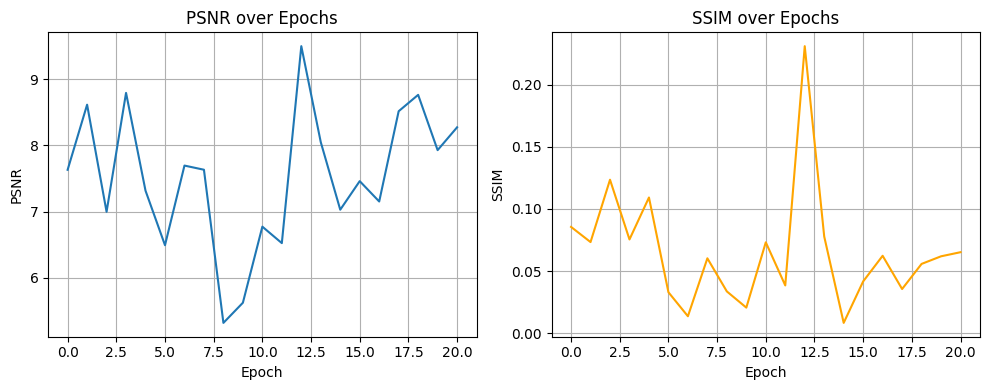

In [17]:
# Plot training metrics
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(psnr_vals, label='PSNR')
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR over Epochs')
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(ssim_vals, label='SSIM', color='orange')
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.title('SSIM over Epochs')
plt.grid(True)
plt.tight_layout()
plt.savefig("metrics_plot.png")
plt.show()

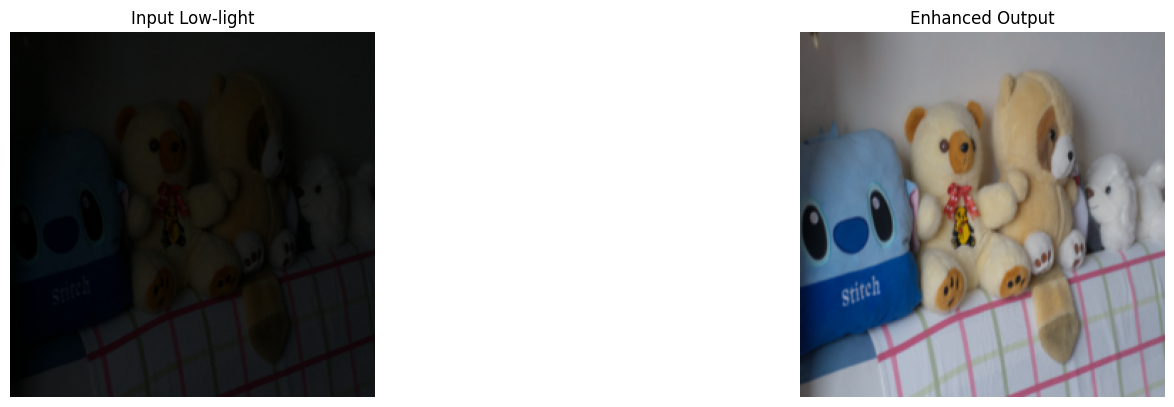

In [18]:
model.eval()
x, y, h, _ = trainset[0]
with torch.no_grad():
    model.set_hist(h.unsqueeze(0).to(device))
    out, _ = model(x.unsqueeze(0).to(device))

input_img = x.permute(1, 2, 0).cpu().numpy()
gt_img = y.permute(1, 2, 0).cpu().numpy()
output_img = out.squeeze(0).permute(1, 2, 0).cpu().numpy()

input_img = np.clip(input_img, 0, 1)
gt_img = np.clip(gt_img, 0, 1)
output_img = np.clip(output_img, 0, 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(input_img)
plt.title("Input Low-light")
plt.axis('off')


plt.subplot(1, 3, 3)
plt.imshow(gt_img)
plt.title("Enhanced Output")
plt.axis('off')

plt.tight_layout()
plt.savefig("visual_comparison.png")
plt.show()